# Test plane extraction for a single point cloud

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.mesh as mesh
import planeslam.general as general
from planeslam.scanrep import ScanRep

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read Point Cloud from pcd file

In [3]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

Cluster the points

In [4]:
start_time = time.time()
P = general.downsample(P, factor=5, axis=0)
m = mesh.lidar_mesh(P)
# Prune the mesh for long edges
m = mesh.prune_mesh(P, m, 10)
# Cluster the mesh with graph search
clusters, avg_normals = mesh.cluster_mesh_graph_search(P, m)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.29924559593200684


Text(0.5, 0.5, 'Y')

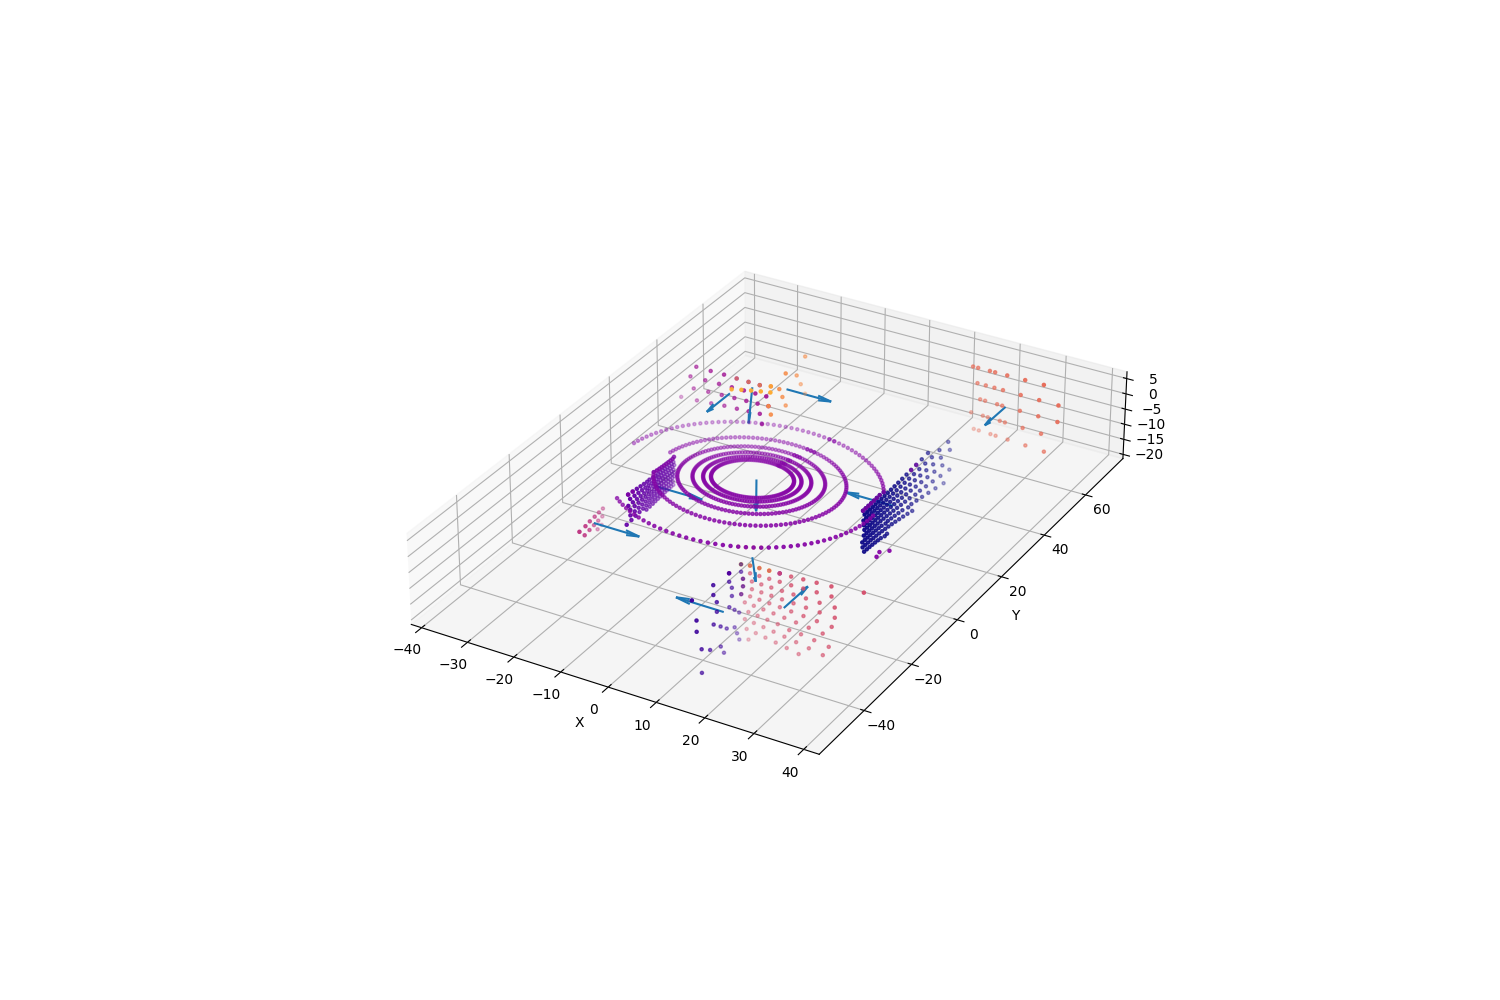

In [5]:
# Plot clusters
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color=colors[i,:], marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")


Extract planes

In [14]:
vertices, faces, normals = mesh.scan_from_clusters(P, m, clusters, avg_normals)
scan = ScanRep(vertices, faces, normals)

Text(0.5, 0.5, 'Y')

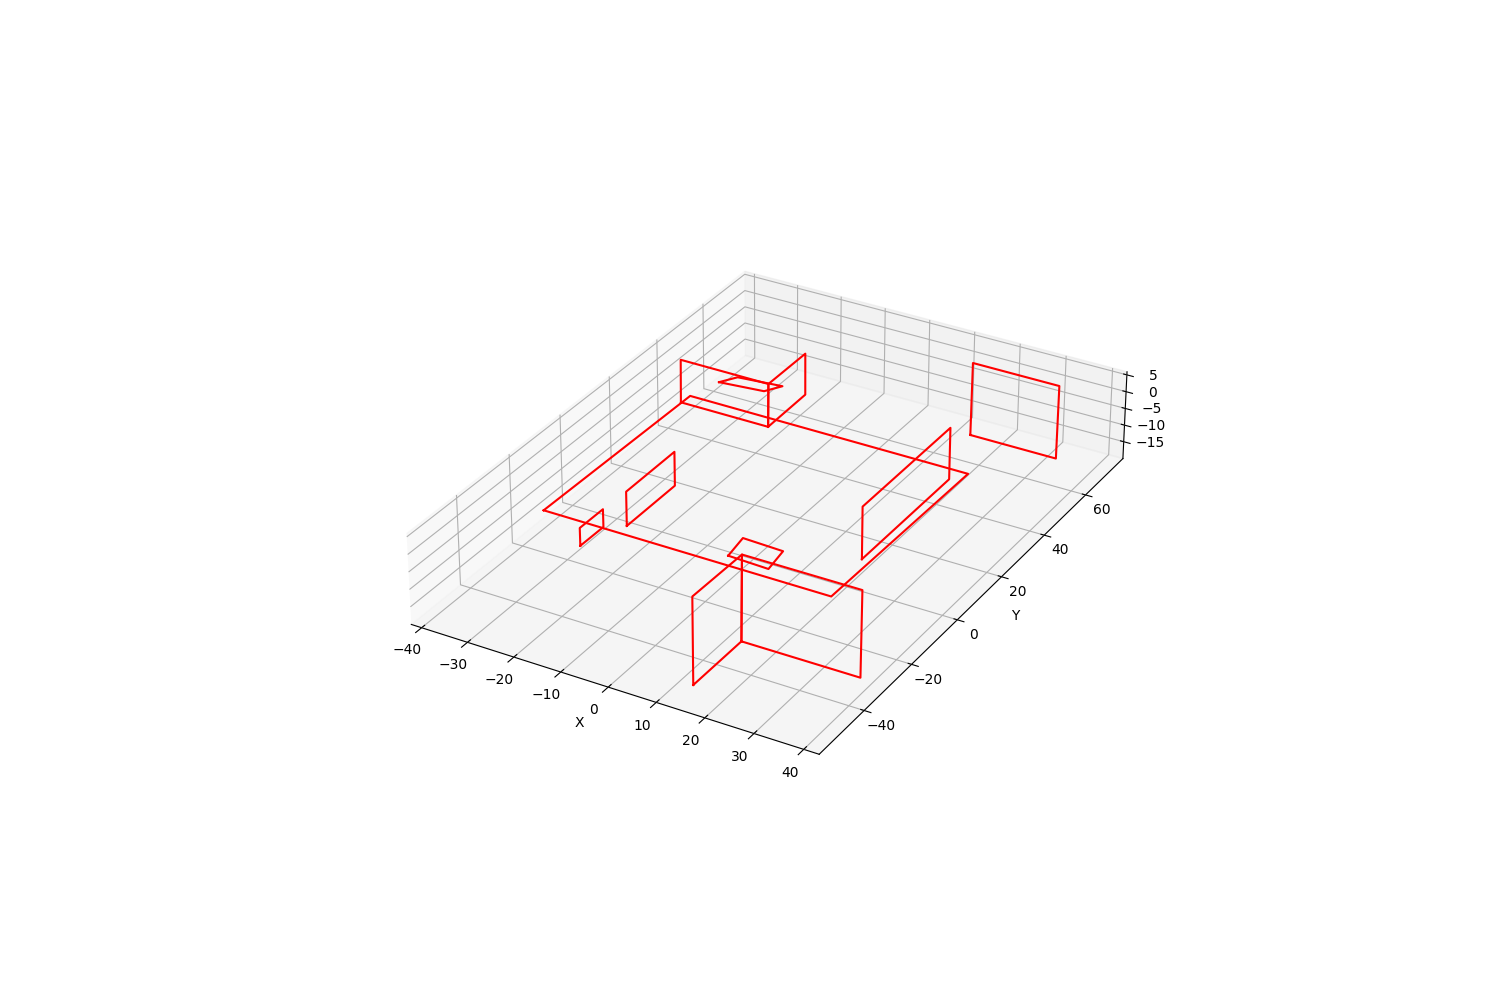

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r')

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")